from google.colab import drive
drive.mount('/content/gdrive')

%cd 'gdrive/My Drive/caption_generation_clone/Image_object_detection_and_caption_genration'

In [49]:
import pandas as pd
import numpy as np
import re
import os
from pickle import dump, load
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout
from tensorflow.keras.layers import add
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.xception import Xception, preprocess_input
import urllib.request
from PIL import Image
import matplotlib.pyplot as plt
import argparse

!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip

!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip

!unzip \*.zip  && rm *.zip

In [2]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [3]:
def read_file(path_name):
    f = open(path_name)
    return f.read()

In [8]:
def load_training_photos():
    image_names = read_file("Data/Flickr_8k.trainImages.txt")
    image_names.split("\n")
    return image_names

In [9]:
def get_clean_description(training_images):
    training_desc = {}
    descriptions = read_file("clean_description.txt")
    descriptions = descriptions.split("\n")
    for desc in descriptions:
        title, caption = desc.split("\t")
        if title in training_images:
            caption = "<start>" + caption + "<end>"
            if title in training_desc:
                training_desc[title].append(caption)
            else:
                
                training_desc[title] = [caption]
    return training_desc

In [10]:
def load_features(training_images):
    all_features = load(open("features.p","rb"))
    features = {k:all_features[k] for k in training_images}
    return features

In [11]:
training_images = load_training_photos()

In [12]:
training_desc = get_clean_description(training_images)

In [13]:
list(training_desc.items())[:3]

[('1000268201_693b08cb0e.jpg',
  ['<start>a child in a pink dress is climbing up a set of stairs in an entry way <end>',
   '<start>a girl going into a wooden building <end>',
   '<start>a little girl climbing into a wooden playhouse <end>',
   '<start>a little girl climbing the stairs to her playhouse <end>',
   '<start>a little girl in a pink dress going into a wooden cabin <end>']),
 ('1001773457_577c3a7d70.jpg',
  ['<start>a black dog and a spotted dog are fighting<end>',
   '<start>a black dog and a tri colored dog playing with each other on the road <end>',
   '<start>a black dog and a white dog with brown spots are staring at each other in the street <end>',
   '<start>two dogs of different breeds looking at each other on the road <end>',
   '<start>two dogs on pavement moving toward each other <end>']),
 ('1002674143_1b742ab4b8.jpg',
  ['<start>a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl <end>',
   '<start>a little girl is sitting 

In [14]:
features = load_features(training_images.split("\n")[:-1])

In [15]:
list(features.items())[:3]

[('2513260012_03d33305cf.jpg',
  array([[0.        , 0.39944476, 0.00230728, ..., 0.24724662, 0.00611375,
          0.01884155]], dtype=float32)),
 ('2903617548_d3e38d7f88.jpg',
  array([[0.14825103, 0.0083261 , 0.10619269, ..., 0.09697448, 0.24103813,
          0.031633  ]], dtype=float32)),
 ('3338291921_fe7ae0c8f8.jpg',
  array([[0.3214843 , 0.        , 0.00088847, ..., 0.        , 0.04906381,
          0.        ]], dtype=float32))]

### extract training vector features 

In [16]:
def get_training_features(training_images, features):
    training_features = {}
    for img, vector in features.items():
        if img in training_images:
            training_features[img] = vector
    return training_features

In [17]:
training_features = get_training_features(training_images, features)

In [18]:
len(training_features.keys())

6000

### Tokenizing the vocabulary of training data

In [19]:
list_desc = []
for img in training_desc:
    [list_desc.append(d) for d in training_desc[img]]

In [20]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(list_desc)

In [21]:
dump(tokenizer, open('tokenizer.p', 'wb'))

In [22]:
len(tokenizer.word_counts)

7333

In [23]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

7334

### Maximum length of a description 

In [24]:
max_length = max(len(d.split()) for d in list_desc)

### number of training instances (images) 

In [25]:
len(training_desc.keys())

6000

In [26]:
feat_file = open('features.p', 'rb')

features = load(feat_file)

feat_file.close()

### Every training image will have 2048 features

In [27]:
list(features.items())[0][1].shape

(1, 2048)

### 2048 features in addition of the number of tokens from the description (max = 32) is impossible to handle into memory while training 6000 images

In [28]:
def create_data_sequences(tokenizer, max_length, img_desc, features):
    """
        for each input instances, this function will create a sequence of description tokens as an input and the next token as an output
        X1: feature vector of the input image
        X2: sequence of input tokens of each description
        Y: the next token of the input sequence
    """
    X1, X2, Y = [], [], []
    for desc in img_desc:
        seq = tokenizer.texts_to_sequences([desc])[0]
        for i in range(1, len(seq)):
            input_seq, output_seq = seq[:i], seq[i]
            input_seq = pad_sequences([input_seq], max_length)[0] #to make sure the input has len=32 for all sequnces of descriptions
            output_seq = to_categorical([output_seq], num_classes=vocab_size)[0]
            X1.append(features)
            X2.append(input_seq)
            Y.append(output_seq)
    return np.array(X1).reshape(np.array(X1).shape[0], np.array(X1).shape[2]), np.array(X2), np.array(Y)

### Since w have a lot of data we will use a generator to create the input features and the input sequences for each instance
### The generator will only be executed once and the yield function will return the generated data one by one
### this method will help us save memory since we don't need to store the data, they will only be used while training

In [29]:
def generate_data(training_desc, features, tokenizer, max_length):
    while 1:
        for key, img_descs in training_desc.items():
            img_feature_vector = features[key]
            input_image, input_sequence, output = create_data_sequences(tokenizer, max_length, img_descs, img_feature_vector)
            yield ([input_image, input_sequence], output)

In [30]:
[a,b],c = next(generate_data(training_desc, features, tokenizer, max_length))

### a represents the input matrix of the vector feature
- 2048 is length on the vector feature (the output shape of the Xception architecture we used earlier to extract features)
- 58 the number of sequences (tokens of the description) generated for the image

In [31]:
a.shape

(58, 2048)

### b is the matrix that contains the input sequences of the description of an instance
- 58 number of sequences generated
- 37 length of the sequence (max length of a description)

In [32]:
b.shape

(58, 37)

### c is the output matrix which represents the next token of the input sequence
- 58 the number of sequences of an input instance, so we need the next token for each sequence
- 7334 the number of existing unique words in the vocabulary of the description (training intances), we converted the vocabulary to a binary representation (vector of 0s and 1) since the computer doesn't understand englidh words

In [33]:
c.shape

(58, 7334)

# Modeling 

In [47]:
input_features = Input(shape=(2048,))
regul_drop = Dropout(0.5)(input_features)
dense1 = Dense(256, activation="relu")(regul_drop)

input_seq = Input(shape=(max_length,))
layer1 = Embedding(vocab_size, 256, mask_zero=True)(input_seq)
regul_drop_seq = Dropout(0.5)(layer1)
lstm_layer =LSTM(256)(regul_drop_seq)

decoder1 = add([dense1, lstm_layer])

decoder2 = Dense(256, activation="relu")(decoder1)
output = Dense(vocab_size, activation="softmax")(decoder2)

model = Model(inputs=[input_features, input_seq], outputs=output)
model.compile(loss="categorical_crossentropy", optimizer='adam')

In [35]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 37)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 37, 256)      1877504     input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_1[0][0]                    
______________________________________________________________________________________________

plot_model(model, to_file='model.png', show_shapes=True)

### Training 

In [47]:
epochs = 3
steps = len(training_desc)

for i in range(3):
    generator = generate_data(training_desc, training_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)
    model.save("models/model_" + str(i) + ".h5")

6000/6000 [==============================] - 670s 112ms/step - loss: 2.7806


### Validation 

### Testing the model

In [88]:
def extract_features(filename, model):
    try:
        s = Image.open(filename)
    except:
        print("Error: Couldn't open the image!")
    
    s = s.resize((299, 299))
    s = np.array(s)
    if s.shape[2] == 4:
        s = s[..., :3]
    s = np.expand_dims(s, axis=0)
    s = s/255
    feature = model.predict(s)
    return feature

In [89]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
         if index == integer:
            return word
    return None

In [90]:
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text

In [91]:
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
model.load_weights('models/model_2.h5')
xception_model = Xception(include_top=False, pooling="avg")




start a man is walking along a snowy mountain end


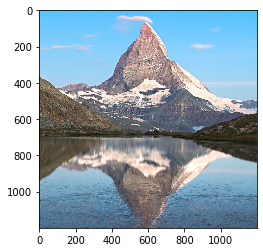

In [95]:
img_path = "Data\Test Images/111.jpg"
photo = extract_features(img_path, xception_model)
sss = Image.open(img_path)
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(sss)